load the file 

In [1]:
import pandas as pd 
df = pd.read_csv('/home/gdt-ws4/Downloads/protein_bond.csv')

In [2]:
df

,Unnamed: 0,prot_id,protein_seq,secondary_structure,number_of_bonds
0,0,1BSOA,LIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEEL...,CCCCCCCTTCCTTTTCEECEEEEEEESSHHHHSSTTCTTCEEEEEE...,4
1,1,1BT3A,APIQAPEISKCVVPPADLPPGAVVDNCCPPVASNIVDYKLPAVTTM...,CCCCCCCGGGCCSSCTTCCTTCSCSCCCCCCCSSEEECCCCCCSSC...,4
2,2,1B2TA,MQHHGVTKCNITCSKMTSKIPVALLIHYQQNQASCGKRAIILETRQ...,CCSSCCCCSSSCCSSCCCCCCGGGEEEEEECCTTTSSSCEEEEETT...,4
3,3,1B32A,ADVPAGVQLADKQTLVRNNGSEVQSLDPHKIEGVPESNVSRDLFEG...,CCCCTTCCBCSSCEEEEECSSCCSCSCTTSCCBHHHHHHHHHHCCC...,2
4,4,1A2JA,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,CCSCBTTTEEECSSCCTTCCSEEEEECTTCHHHHHHHHTSCHHHHH...,2
...,...,...,...,...,...
1013,1013,3SSIA,LYAPSALVLTVGKGVSATTAAPERAVTLTCAPGPSGTHPAAGSACA...,CCCCCEEEEEEEESSSTTTCCCCEEEEEECSSSCBSSSTTHHHHHH...,4
1014,1014,3UAGA,ADYQGKNVVIIGLGLTGLSCVDFFLARGVTPRVMDTRMTPPGLDKL...,CCCTTCCEEEECCSHHHHHHHHHHHTTTCCCEEEESSSSCTTGGGS...,2
1015,1015,4DPVZ,GSGNGSGGGGGGGSGGVGISTGTFNNQTEFKFLENGWVEITANSSR...,CCCCCCCCCCEETTEETTBCCCCCCCCEEEEECTTSEEEEEEEEEE...,2
1016,1016,5R1RA,MNQNLLVTKRDGSTERINLDKIHRVLDWAAEGLHNVSISQVELRSH...,CCCCCBCBBTTTBCCBCCHHHHHHHHHHHHTTCSSCCHHHHHHHHH...,2


In [ ]:
# # Read the text file line by line
# with open('disulfide.txt', 'r') as file:
#     for line in file:
#         # Split each line by spaces
#         values = line.split(' ')
#         print(values)
#         # Process the values as needed
       

In [ ]:
# # Initialize a list to store data
# data_list = []
# current_data = []

# # Read the text file line by line
# with open('disulfide.txt', 'r') as file:
#     for line in file:
#         line = line.strip()  # Remove leading/trailing whitespace
#         if line:
#             # Append the line to the current_data list
#             current_data.append(line)
#         else:
#             # If a blank line is encountered, append the current_data list to the data_list
#             if current_data:
#                 data_list.append(current_data)
#             current_data = []  # Create a new list for the next section

# # Append the last section to the data_list if not empty
# if current_data:
#     data_list.append(current_data)

# # Display the list of lists
# for section_data in data_list:
#     print(section_data)


In [3]:
df.columns

Index(['Unnamed: 0', 'prot_id', 'protein_seq', 'secondary_structure',
       'number_of_bonds'],
      dtype='object')

Plot the Data

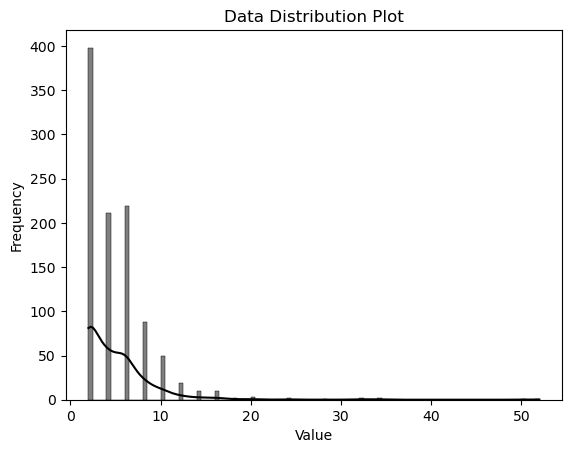

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['number_of_bonds'], bins=100, kde=True,color='black')  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Data Distribution Plot')

# Display the plot
plt.show()


In [9]:
df['target'] = (df['number_of_bonds']/df['seq_len']) *10

Get the length of each protein sequence length

In [8]:
df['seq_len'] = df['protein_seq'].apply(len)

Text(0, 0.5, 'Target values')

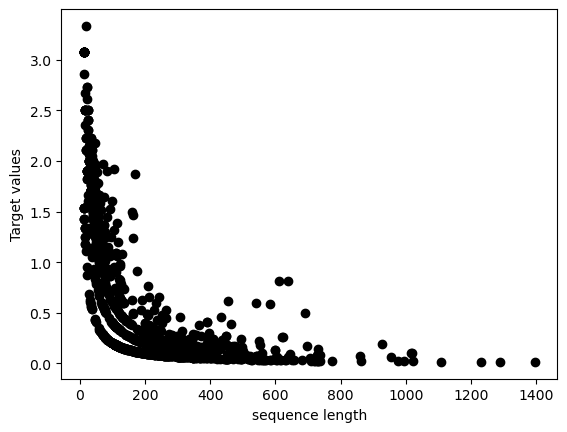

In [10]:
import matplotlib.pyplot as plt
plt.scatter(df['seq_len'],df['target'],color='black')
plt.xlabel('sequence length')
plt.ylabel('Target values')

Text(0, 0.5, 'number of bonds')

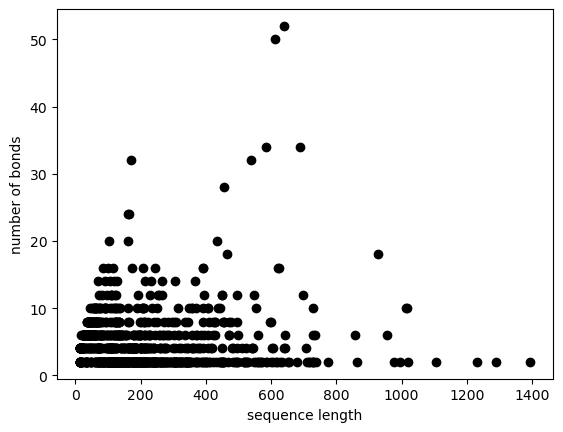

In [11]:
import matplotlib.pyplot as plt
plt.scatter(df['seq_len'],df['number_of_bonds'],color='black')
plt.xlabel('sequence length')
plt.ylabel('number of bonds')

In [12]:
max_sequence_length = max(len(seq) for seq in protein_seq)

# Pad sequences to the maximum length
padded_sequences = pad_sequences(all, maxlen=max_sequence_length, padding='post', truncating='post', dtype='float32')

# Convert the padded_sequences list to a numpy array
X = np.array(padded_sequences)

# Convert the delta_g_values to a numpy array
# y = np.array(delta_g_values)

NameError: name 'protein_seq' is not defined

In [13]:
df.columns

Index(['Unnamed: 0', 'prot_id', 'protein_seq', 'secondary_structure',
       'number_of_bonds', 'seq_len', 'target'],
      dtype='object')

In [14]:
df['number_of_bonds']

0       4
1       4
2       4
3       2
4       2
       ..
1013    4
1014    2
1015    2
1016    2
1017    2
Name: number_of_bonds, Length: 1018, dtype: int64

converted the target sequence 

In [15]:
df['target'] = (df['number_of_bonds']/df['seq_len']) *10

In [16]:
df['target']

0       0.246914
1       0.119048
2       0.519481
3       0.038685
4       0.106383
          ...   
1013    0.370370
1014    0.046512
1015    0.035778
1016    0.027100
1017    0.952381
Name: target, Length: 1018, dtype: float64

In [17]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

2023-11-30 13:31:14.539115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 13:31:14.539146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 13:31:14.541028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 13:31:14.649014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2023-11-30 13:31:15.502558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Do the one hot encoding of each original sequence and secondary sequence

In [18]:
import numpy as np

# Define your list of amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Create a dictionary to map amino acids to indices
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

# Function to one-hot encode a sequence
def one_hot_encode_sequence(sequence):
    sequence_length = len(sequence)
    num_classes = len(amino_acids)
    one_hot_encoded = np.zeros((sequence_length, num_classes))
    
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            one_hot_encoded[i, aa_to_index[aa]] = 1
        else:
            # Handle the case where the amino acid is not in the dictionary
            # You can choose to ignore it, set a default value, or perform some other action
            pass
    
    return one_hot_encoded

# Example protein sequences
protein_sequences = df['protein_seq']
# Encode the sequences
all_dot_products = [one_hot_encode_sequence(seq) for seq in protein_sequences]
# structures = df['secondary_structure']
# import numpy as np

# all_dot_products = []

# for i in range(len(encoded_seq)):
#     all_dot =  encoded_seq[i]
#     all_dot_products.append(all_dot)


In [19]:
df['protein_seq']

0       LIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEEL...
1       APIQAPEISKCVVPPADLPPGAVVDNCCPPVASNIVDYKLPAVTTM...
2       MQHHGVTKCNITCSKMTSKIPVALLIHYQQNQASCGKRAIILETRQ...
3       ADVPAGVQLADKQTLVRNNGSEVQSLDPHKIEGVPESNVSRDLFEG...
4       AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...
                              ...                        
1013    LYAPSALVLTVGKGVSATTAAPERAVTLTCAPGPSGTHPAAGSACA...
1014    ADYQGKNVVIIGLGLTGLSCVDFFLARGVTPRVMDTRMTPPGLDKL...
1015    GSGNGSGGGGGGGSGGVGISTGTFNNQTEFKFLENGWVEITANSSR...
1016    MNQNLLVTKRDGSTERINLDKIHRVLDWAAEGLHNVSISQVELRSH...
1017                                GSKKPVPIIYCNRRTGKCQRM
Name: protein_seq, Length: 1018, dtype: object

In [20]:
# Assuming 'df' is your DataFrame
protein_sequences = df['protein_seq']
delta_g_values = df['target']

amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Create a dictionary to map amino acids to indices
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

# Function to one-hot encode a sequence
def one_hot_encode_sequence(sequence):
    sequence_length = len(sequence)
    num_classes = len(amino_acids)
    one_hot_encoded = np.zeros((sequence_length, num_classes))
    
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            one_hot_encoded[i, aa_to_index[aa]] = 1
        else:
            # Handle the case where the amino acid is not in the dictionary
            # You can choose to ignore it, set a default value, or perform some other action
            pass
    
    return one_hot_encoded
# One-hot encode all the protein sequences in the DataFrame
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have a list of one-hot encoded sequences
encoded_sequences = [one_hot_encode_sequence(seq) for seq in protein_sequences]

#Find the maximum sequence length
max_sequence_length = max(len(seq) for seq in encoded_sequences)

# Pad sequences to the maximum length
padded_sequences = pad_sequences(encoded_sequences, maxlen=max_sequence_length, padding='post', truncating='post', dtype='float32')

# Convert the padded_sequences list to a numpy array
X = np.array(padded_sequences)

# Convert the delta_g_values to a numpy array
y = np.array(delta_g_values)
del protein_sequences
del delta_g_values
del encoded_sequences
del padded_sequences

In [21]:
max_sequence_length

1395

In [22]:
X 

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [23]:
# y = df['target']
# y = np.array(y)

In [24]:
# Split the data into 70% training and 30% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3,random_state=42)

# # Split the remaining data (30%) into 10% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=42)

# # Print the shapes of the datasets
print("Training data shapes:", X_train.shape, y_train.shape)
print("Validation data shapes:", X_val.shape, y_val.shape)
print("Test data shapes:", X_test.shape, y_test.shape)


Training data shapes: (712, 1395, 20) (712,)
Validation data shapes: (100, 1395, 20) (100,)
Test data shapes: (206, 1395, 20) (206,)


In [25]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Set the input shape and number of classes (1 for regression)
input_shape = (X_train.shape[1],X_train.shape[2]) # Sequence length and number of channels
num_classes = 1

# Create the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=1))  # Keep this pooling layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='linear'))


# Compile the model with appropriate loss function and optimizer
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# Apply learning rate scheduling
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

# Train the model using the training dataset and validate on the validation set
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

# Evaluate the model on the test dataset
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)


2023-11-30 13:31:39.884597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 13:31:39.992884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 13:31:39.993339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-11-30 13:31:42.770318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 13:31:44.676100: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcb2997ea60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-30 13:31:44.676119: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-30 13:31:44.682798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-30 13:31:44.754181: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 [==============================] - 5s 34ms/step - loss: 0.9042 - val_loss: 0.1535 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 0s 9ms/step - loss: 0.1745 - val_loss: 0.1066 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.1428 - val_loss: 0.1003 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 0.1286 - val_loss: 0.0966 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 0.1092 - val_loss: 0.0884 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0914 - val_loss: 0.0865 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0728 - val_loss: 0.0737 - lr: 0.0010
Epoch 8/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0524 - val_loss: 0.0498 - lr: 0.0010
Epoch 9/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0448 - val_loss: 0.0428 - lr: 0.0010
Epo

In [26]:
# Assuming you have predictions and true values as numpy arrays
prediction = model.predict(X_test)
y_true = np.array(y_test)  # True delta_G values for the test data
y_pred = prediction.reshape(-1)  # Reshape predictions to a 1D array if needed

# Calculate mean squared error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Calculate coefficient of determination (R-squared score)
r2_score_value = r2_score(y_true, y_pred)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("R-squared Score:", r2_score_value)


7/7 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 0.044026403544879064
R-squared Score: 0.9194069247704834


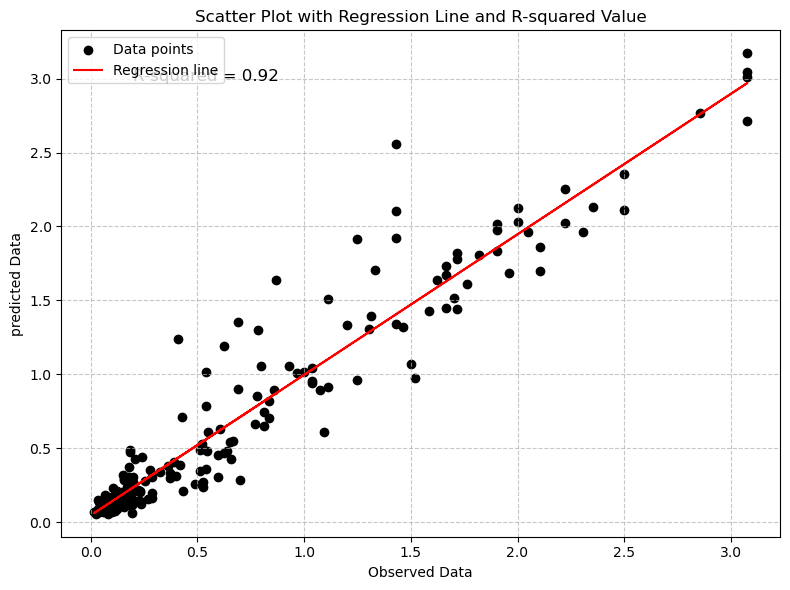

In [27]:
import matplotlib.pyplot as plt
regression_line = np.polyfit(y_true, y_pred, 1)
regression_fn = np.poly1d(regression_line)

# Calculate the R-squared value
r2 = r2_score(y_true, y_pred)

# Create a scatter plot with regression line and R-squared value
plt.figure(figsize=(8, 6))

plt.scatter(y_true, y_pred, color='black', label='Data points')
plt.plot(y_true, regression_fn(y_true), color='red', label='Regression line')

# Annotate with R-squared value
plt.annotate(f'R-squared = {r2:.2f}', (0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel('Observed Data')
plt.ylabel('predicted Data')
plt.title('Scatter Plot with Regression Line and R-squared Value')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



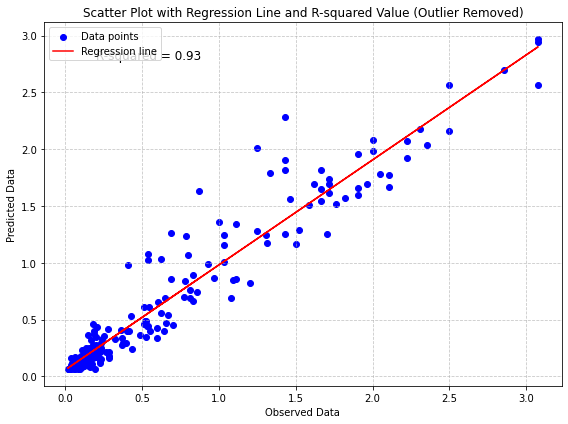

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
outlier_index = np.argmax(y_pred)  # Find the index of the outlier
y_true = np.delete(y_true, outlier_index)
y_pred = np.delete(y_pred, outlier_index)

# Calculate the regression line and R-squared value after removing the outlier
regression_line = np.polyfit(y_true, y_pred, 1)
regression_fn = np.poly1d(regression_line)
r2 = r2_score(y_true, y_pred)

# Create a scatter plot with regression line and R-squared value
plt.figure(figsize=(8, 6))

plt.scatter(y_true, y_pred, color='blue', label='Data points')
plt.plot(y_true, regression_fn(y_true), color='red', label='Regression line')

# Annotate with R-squared value
plt.annotate(f'R-squared = {r2:.2f}', (0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel('Observed Data')
plt.ylabel('Predicted Data')
plt.title('Scatter Plot with Regression Line and R-squared Value (Outlier Removed)')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [42]:
model.save('di_sulphite_bond.h5')